In [32]:
!pip install qutip --quiet

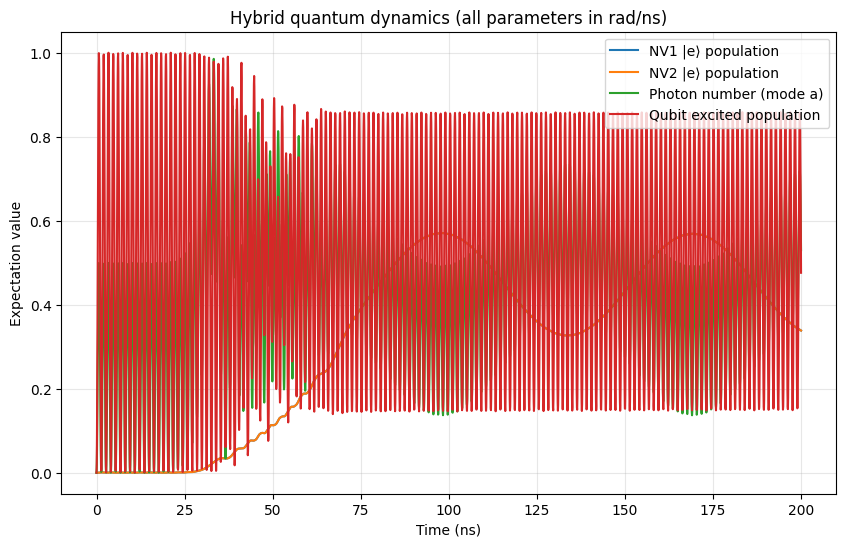

In [33]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


# 1. UNIT SYSTEM
# We work entirely in rad/ns because:
# - Schrödinger equation uses angular frequency (rad)
# - The time grid is in nanoseconds (ns)
# - Hamiltonian, drive terms and decay rates must be consistent

two_pi = 2 * np.pi

# Convert MHz → rad/ns
# 1 MHz = 10^6 Hz = 10^-3 GHz, and ω = 2π f
def MHz_to_radns(MHz):
    return two_pi * MHz * 1e-3

# Convert rates given in 1/μs → 1/ns
def per_us_to_per_ns(rate):
    return rate * 1e-3


# 2. TIME GRID (ns)
# Hamiltonian terms must be in rad/ns to match this scale.
t_max_ns = 200.0
n_points = 3000
times = np.linspace(0, t_max_ns, n_points)


# 3. PHYSICAL PARAMETERS (from the Wu paper)
# All values are given in MHz for uniform conversion.

# Transition frequencies (2 GHz → 2000 MHz)
omega_a_MHz  = 2000.0
omega_b_MHz  = 2000.0
omega_eg_MHz = 2000.0
omega_ge1_MHz = 2000.0
omega_ge2_MHz = 2000.0

# NV |g> → |u> transition (2.8 GHz → 2800 MHz)
omega_gu1_MHz = 2800.0
omega_gu2_MHz = 2800.0

# Coupling strengths
g_a_MHz = 260.0   # resonator–qubit
g_b_MHz = 260.0
g1_MHz  = 7.0     # resonator–NV1
g2_MHz  = 7.0     # resonator–NV2


# 4. CONVERT ALL PARAMETERS TO rad/ns
g_a = MHz_to_radns(g_a_MHz)
g_b = MHz_to_radns(g_b_MHz)
g1  = MHz_to_radns(g1_MHz)
g2  = MHz_to_radns(g2_MHz)

omega_a  = MHz_to_radns(omega_a_MHz)
omega_b  = MHz_to_radns(omega_b_MHz)
omega_eg = MHz_to_radns(omega_eg_MHz)
omega_ge1 = MHz_to_radns(omega_ge1_MHz)
omega_ge2 = MHz_to_radns(omega_ge2_MHz)
omega_gu1 = MHz_to_radns(omega_gu1_MHz)
omega_gu2 = MHz_to_radns(omega_gu2_MHz)


# 5. DETUNINGS
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg

delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2


# 6. GAUSSIAN DRIVE PULSE (qubit drive)
t0 = 50.0
sigma_t = 10.0

def gauss_env(t):
    return np.exp(-((t - t0)**2) / (2 * sigma_t**2))

# Pulse amplitude scaled relative to g_a
Omega = 0.6 * abs(g_a)


# 7. OPERATOR DEFINITIONS
# The Hilbert space is:
# (resonator a) x (resonator b) x (qubit) x (NV1) x (NV2)
# = 2 × 2 × 2 × 3 × 3 = 72 levels

def tensor_op(*ops):
    return qt.tensor(*ops)

# Resonator annihilation operators
a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))

# Qubit raising and lowering
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

# NV operator generator: |i><j| acting on NV index
def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

# NV1 transitions
S1_ge_plus  = S_op(3,1,0,3)
S1_ge_minus = S_op(3,0,1,3)
S1_gu_plus  = S_op(3,2,0,3)
S1_gu_minus = S_op(3,0,2,3)

# NV2 transitions
S2_ge_plus  = S_op(3,1,0,4)
S2_ge_minus = S_op(3,0,1,4)
S2_gu_plus  = S_op(3,2,0,4)
S2_gu_minus = S_op(3,0,2,4)


# 8. TIME-DEPENDENT HAMILTONIAN (Interaction Picture, RWA)
# Each entry is [operator, time_function]
H_t = [

    # Resonator-qubit interactions
    [g_a * a * sigma_plus,        lambda t, args: np.exp(1j * delta_a * t)],
    [g_a * a.dag() * sigma_minus, lambda t, args: np.exp(-1j * delta_a * t)],

    [g_b * b * sigma_plus,        lambda t, args: np.exp(1j * delta_b * t)],
    [g_b * b.dag() * sigma_minus, lambda t, args: np.exp(-1j * delta_b * t)],

    # NV1 interactions
    [g1 * a * S1_ge_plus,        lambda t, args: np.exp(1j * delta1_ge * t)],
    [g1 * a.dag() * S1_ge_minus, lambda t, args: np.exp(-1j * delta1_ge * t)],
    [g1 * a * S1_gu_plus,        lambda t, args: np.exp(1j * delta1_gu * t)],
    [g1 * a.dag() * S1_gu_minus, lambda t, args: np.exp(-1j * delta1_gu * t)],

    # NV2 interactions
    [g2 * b * S2_ge_plus,        lambda t, args: np.exp(1j * delta2_ge * t)],
    [g2 * b.dag() * S2_ge_minus, lambda t, args: np.exp(-1j * delta2_ge * t)],
    [g2 * b * S2_gu_plus,        lambda t, args: np.exp(1j * delta2_gu * t)],
    [g2 * b.dag() * S2_gu_minus, lambda t, args: np.exp(-1j * delta2_gu * t)],

    # Gaussian drive on the qubit/resonators
    [a,     lambda t, args: Omega * gauss_env(t) * np.exp(1j * delta_a * t)],
    [a.dag(), lambda t, args: np.conj(Omega * gauss_env(t) * np.exp(1j * delta_a * t))],
    [b,     lambda t, args: Omega * gauss_env(t) * np.exp(1j * delta_b * t)],
    [b.dag(), lambda t, args: np.conj(Omega * gauss_env(t) * np.exp(1j * delta_b * t))],
]


# 9. DECOHERENCE CHANNELS
# All decay times are 20 μs (from the paper).
# Converted to per-ns rates for consistency.
kappa     = per_us_to_per_ns(1/20)
gamma_q   = per_us_to_per_ns(1/20)
gamma_phi = per_us_to_per_ns(1/200)

c_ops = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi) * (sigma_plus * sigma_minus)
]


# 10. INITIAL STATE (all ground/vacuum)
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)


# 11. EXPECTATION VALUES TO BE RECORDED
pop_NVE1_e = S_op(3,1,1,3)
pop_NVE2_e = S_op(3,1,1,4)
photon_a = a.dag()*a
qubit_pop = sigma_plus.dag()*sigma_plus

e_ops = [pop_NVE1_e, pop_NVE2_e, photon_a, qubit_pop]


# 12. SOLVE THE OPEN-SYSTEM DYNAMICS
#result = qt.mesolve(H_t, psi0, times, c_ops, e_ops=e_ops)

opts = qt.Options(store_states=True)

result = qt.mesolve(
    H_t, psi0, times,
    c_ops, e_ops=e_ops,
    options=opts
)

# 13. PLOT RESULTS
plt.figure(figsize=(10,6))
plt.plot(times, result.expect[0], label="NV1 |e⟩ population")
plt.plot(times, result.expect[1], label="NV2 |e⟩ population")
plt.plot(times, result.expect[2], label="Photon number (mode a)")
plt.plot(times, result.expect[3], label="Qubit excited population")

plt.xlabel("Time (ns)")
plt.ylabel("Expectation value")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Hybrid quantum dynamics (all parameters in rad/ns)")
plt.show()


In [34]:
# CONSTRUCT ρ_T4 (physically correct mixed NV state)

lambda_val = 0.90

# NV basis states
g1 = qt.basis(3,0)
e1 = qt.basis(3,1)
g2 = qt.basis(3,0)
e2 = qt.basis(3,1)

# NV two-qubit basis (only 4 states relevant)
NV_gg = qt.tensor(g1, g2)
NV_ge = qt.tensor(g1, e2)
NV_eg = qt.tensor(e1, g2)
NV_ee = qt.tensor(e1, e2)

# White noise subspace: 4 basis states
rho_white_NV = (
    NV_gg*NV_gg.dag()
  + NV_ge*NV_ge.dag()
  + NV_eg*NV_eg.dag()
  + NV_ee*NV_ee.dag()
) / 4.0

# Pure target NV state
NV_ent = (NV_gg + NV_ee).unit()
rho_T3_NV = NV_ent * NV_ent.dag()

# Embed NV density matrices into full Hilbert space
proj_a = qt.basis(2,0)*qt.basis(2,0).dag()
proj_b = qt.basis(2,0)*qt.basis(2,0).dag()
proj_q = qt.basis(2,0)*qt.basis(2,0).dag()

rho_T3 = qt.tensor(proj_a, proj_b, proj_q, rho_T3_NV)
rho_white_full = qt.tensor(proj_a, proj_b, proj_q, rho_white_NV)

# Final ρ_T4
rho_T4 = lambda_val * rho_T3 + (1 - lambda_val) * rho_white_full


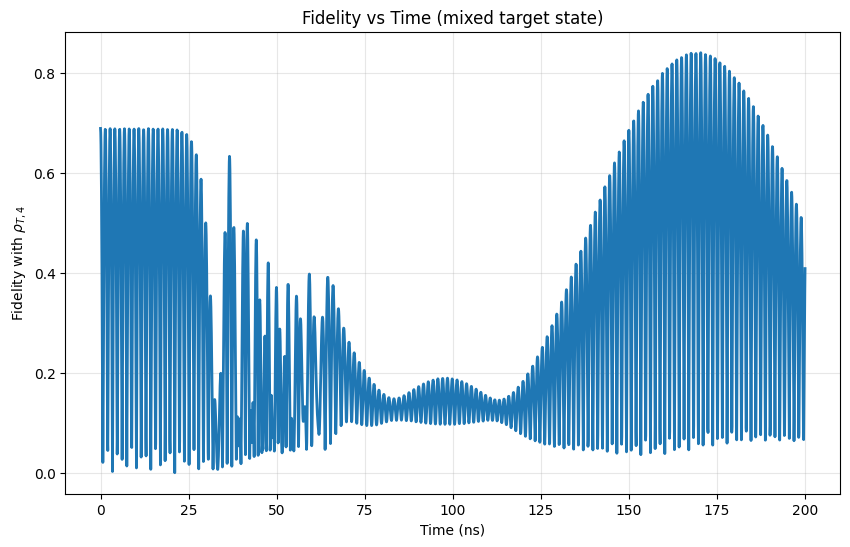

In [35]:
fidelity_T4_t = []

for rho in result.states:
    Fm = qt.fidelity(rho, rho_T4)
    fidelity_T4_t.append(Fm)

plt.figure(figsize=(10,6))
plt.plot(times, fidelity_T4_t, linewidth=2)
plt.xlabel("Time (ns)")
plt.ylabel("Fidelity with $\\rho_{T,4}$")
plt.title("Fidelity vs Time (mixed target state)")
plt.grid(alpha=0.3)
plt.show()
